# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

In [ ]:
! git clone https://github.com/ds3001f25/visualization_assignment.git

Cloning into 'visualization_assignment'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 0), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 1.88 MiB | 4.78 MiB/s, done.


In [ ]:
cd visualization_assignment/

/content/visualization_assignment/visualization_assignment


In [ ]:
%cd data/

/content/visualization_assignment/visualization_assignment/data


In [ ]:
ls -al

total 4820
drwxr-xr-x 2 root root    4096 Sep 11 03:42 ./
drwxr-xr-x 4 root root    4096 Sep 11 03:42 ../
-rw-r--r-- 1 root root 1694435 Sep 11 03:42 college_completion.csv
-rw-r--r-- 1 root root 1646175 Sep 11 03:42 pretrial_data.csv
-rw-r--r-- 1 root root 1582160 Sep 11 03:42 VirginiaPretrialData2017Codebook.pdf


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform
$$
k(z) = \begin{cases}
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is
$$
k(z) = \begin{cases}
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def silverman_bandwidth(x):
    # Silverman's rule of thumb for Gaussian kernel
    # h = 0.9 * min(std, IQR/1.34) * n^{-1/5}
    x = np.asarray(x).ravel()
    n = len(x)
    std = np.std(x, ddof=1)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    sigma = min(std, iqr / 1.34)
    return 0.9 * sigma * n ** (-1/5)

def gaussian_kernel(z):
    return (1/np.sqrt(2 * np.pi)) * np.exp(- 0.5 * z**2)

def uniform_kernel(z):
    # Shortcutting with mask instead of if/else logic (faster than loops)
    out = np.zeros_like(z)
    mask = np.abs(z) <= 1
    out[mask] = 0.5
    return out

def epanechnikov_kernel(z):
    out = np.zeros_like(z)
    mask = np.abs(z) <= 1
    out[mask] = 0.75 * (1 - z[mask]**2)
    return out

def kernel_density_plot(
        x,
        kernel='gaussian',
        bandwidth=None,
        gridsize=100,
        ax=None,
        label='Custom KDE',
        plot=True
    ):
    """
    Custom Kernel Density Estimator plot.
    Inputs:
    - x: 1D data (Pandas Series or NumPy array)
    - kernel: 'gaussian', 'uniform', 'epanechnikov'
    - bandwidth: float, default uses Silverman's rule
    - gridsize: how many x-grid points (default 100)
    - ax: Matplotlib axis to plot on
    - label: legend label
    - plot: if False, just returns grid, density
    """

    x = np.asarray(x).ravel()
    n = len(x)

    # Bandwidth selection
    if bandwidth is None:
        bandwidth = silverman_bandwidth(x)

    # Kernel selection
    kernels = {
        'gaussian': gaussian_kernel,
        'uniform': uniform_kernel,
        'epanechnikov': epanechnikov_kernel
    }
    kernel_func = kernels.get(kernel, gaussian_kernel)

    # Grid for x-axis values (default: span +/-1 bandwidth from data min/max)
    x_min, x_max = x.min() - bandwidth, x.max() + bandwidth
    grid = np.linspace(x_min, x_max, gridsize)

    # Distance calculations: Efficient broadcasting with cdist
    z = (cdist(grid[:, np.newaxis], x[:, np.newaxis]) / bandwidth)
    # z shape: (gridsize, n)

    # Kernel evaluation: sum across all data points for each grid point
    kde_values = kernel_func(z).mean(axis=1) / bandwidth

    # Plotting
    if plot:
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(grid, kde_values, label=label)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.set_title(f"Kernel Density Estimate ({kernel}, h={bandwidth:0.3f})")
        ax.legend()
        return ax
    else:
        return grid, kde_values


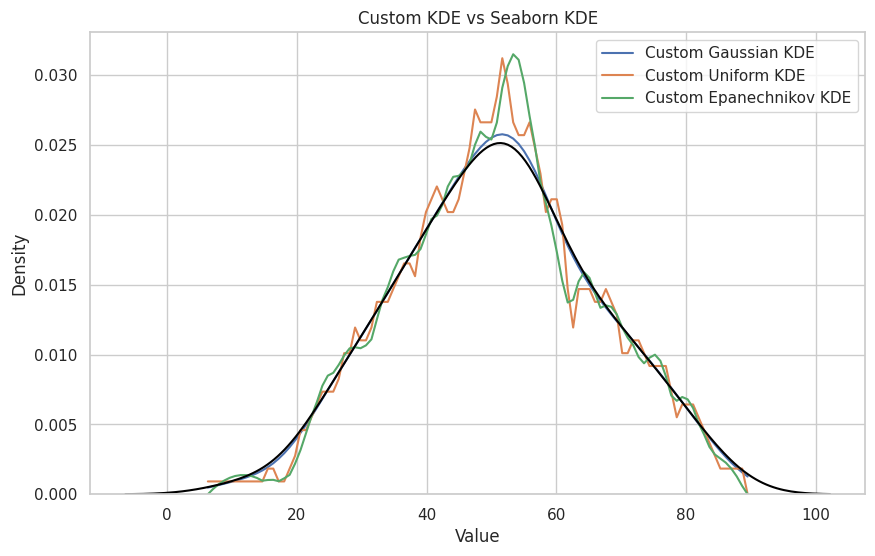

In [88]:
# Simulate 'pretrail' for demo; replace with actual data
pretrial = pd.read_csv('pretrial_data.csv')

np.random.seed(0)
pretrial = pd.Series(np.random.normal(loc=50, scale=15, size=100))

fig, ax = plt.subplots(figsize=(10, 6))

# Custom KDE (default Gaussian)
kernel_density_plot(pretrial, kernel='gaussian', ax=ax, label='Custom Gaussian KDE')

# Also plot Uniform and Epanechnikov for comparison
kernel_density_plot(pretrial, kernel='uniform', ax=ax, label='Custom Uniform KDE')
kernel_density_plot(pretrial, kernel='epanechnikov', ax=ax, label='Custom Epanechnikov KDE')

# Seaborn reference (for visual comparison)
sns.kdeplot(pretrial, ax=ax, color='black', label='Seaborn KDE')

ax.set_title("Custom KDE vs Seaborn KDE")
plt.show()

**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

2.1

In [ ]:
college = pd.read_csv('college_completion.csv')

2.2

In [30]:
college.head()

,index,unitid,chronname,city,state,level,control,basic,hbcu,flagship,...,vsa_grad_elsewhere_after6_transfer,vsa_enroll_after6_transfer,vsa_enroll_elsewhere_after6_transfer,similar,state_sector_ct,carnegie_ct,counted_pct,nicknames,cohort_size,levelXcontrol
0,0,100654,Alabama A&M University,Normal,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,5.6,17.2,11.1,232937|100724|405997|113607|139533|144005|2285...,13,386,99.7|07,NaN,882.0,"4-year, Public"
1,1,100663,University of Alabama at Birmingham,Birmingham,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,NaN,NaN,NaN,196060|180461|201885|145600|209542|236939|1268...,13,106,56.0|07,UAB,1376.0,"4-year, Public"
2,2,100690,Amridge University,Montgomery,Alabama,4-year,Private not-for-profit,Baccalaureate Colleges--Arts & Sciences,NaN,NaN,...,NaN,NaN,NaN,217925|441511|205124|247825|197647|221856|1353...,16,252,100.0|07,NaN,3.0,"4-year, Private not-for-profit"
3,3,100706,University of Alabama at Huntsville,Huntsville,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,0.0,0.0,0.0,232186|133881|196103|196413|207388|171128|1900...,13,106,43.1|07,UAH,759.0,"4-year, Public"
4,4,100724,Alabama State University,Montgomery,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,NaN,NaN,NaN,100654|232937|242617|243197|144005|241739|2354...,13,386,88.0|07,ASU,1351.0,"4-year, Public"


In [31]:
print(college.shape)
print(college.columns)

# dimensions are 63 columns by 3798 observations; columns are listed in the
# printed code block

(3798, 64)
Index(['index', 'unitid', 'chronname', 'city', 'state', 'level', 'control',
       'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count',
       'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value',
       'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value',
       'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile',
       'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile',
       'endow_value', 'endow_percentile', 'grad_100_value',
       'grad_100_percentile', 'grad_150_value', 'grad_150_percentile',
       'pell_value', 'pell_percentile', 'retain_value', 'retain_percentile',
       'ft_fac_value', 'ft_fac_percentile', 'vsa_year',
       'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first',
       'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first',
       'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first',
       'vsa_enroll_after6_first', 'vsa_enroll_elsewhere_after6

2.3

In [32]:
pd.crosstab(college['control'], college['level'])

# Public institutions have the most 2-year programs, which makes sense given that
# most community colleges (2-year programs) are public. The type of institution
# with the lowest proportion of 2-year programs are not-for-profit private
# universities- this is reasonable because private not-for-profit institutions
# tend to be more selective.

level,2-year,4-year
control,,
Private for-profit,465,527
Private not-for-profit,68,1180
Public,926,632


2.4

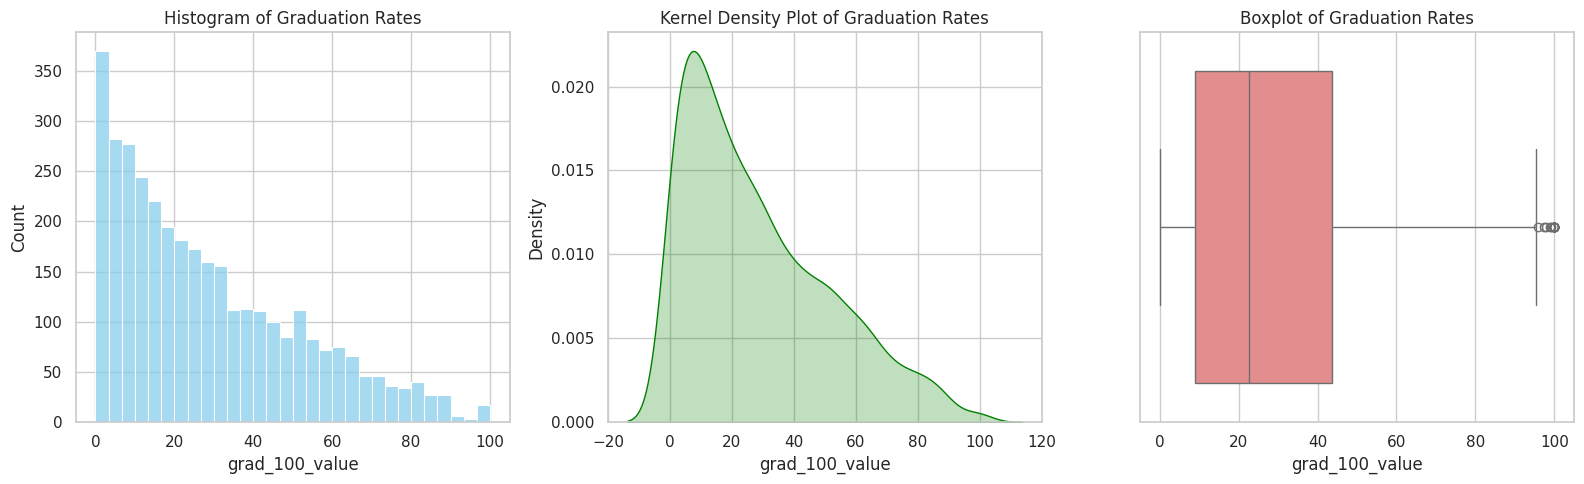

count    3467.000000
mean       28.364465
std        23.312730
min         0.000000
25%         9.000000
50%        22.500000
75%        43.650000
max       100.000000
Name: grad_100_value, dtype: float64


In [38]:
# setting up a seaborn style
sns.set(style="whitegrid")

# setting up a single figure with all of the plots on it
plt.figure(figsize=(16, 5))

# histogram
plt.subplot(1, 3, 1) # arranging subplot position
sns.histplot(college['grad_100_value'].dropna(), kde=False, bins=30, color='skyblue')
plt.title('Histogram of Graduation Rates')
plt.xlabel('grad_100_value')

# kde
plt.subplot(1, 3, 2) # arranging subplot position
sns.kdeplot(college['grad_100_value'].dropna(), fill=True, color='green')
plt.title('Kernel Density Plot of Graduation Rates')
plt.xlabel('grad_100_value')

# boxplot
plt.subplot(1, 3, 3) # arranging subplot position
sns.boxplot(x=college['grad_100_value'], color='lightcoral')
plt.title('Boxplot of Graduation Rates')
plt.xlabel('grad_100_value')

plt.tight_layout()
plt.show()

# statistical description
print(college['grad_100_value'].describe())

2.5

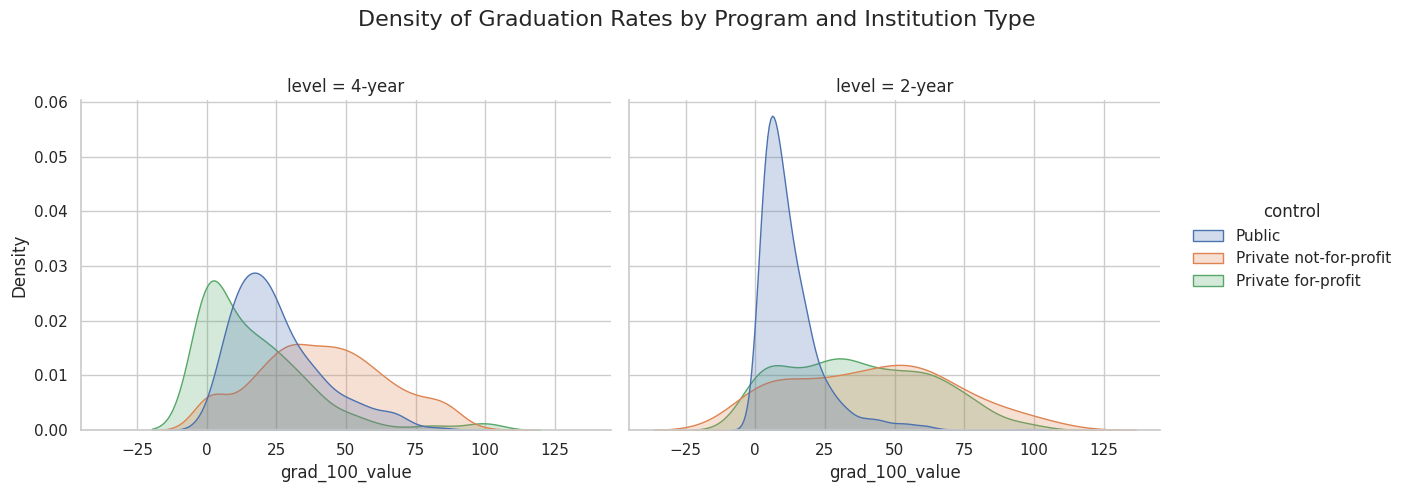

                                count       mean        std  min     25%  \
level  control                                                             
2-year Private for-profit       461.0  37.197614  25.497380  0.0  15.800   
       Private not-for-profit    68.0  41.913235  28.348302  0.0  16.225   
       Public                   926.0  12.400000  10.893600  0.0   5.100   
4-year Private for-profit       318.0  17.382704  20.788525  0.0   0.000   
       Private not-for-profit  1121.0  41.645674  23.243453  0.0  25.000   
       Public                   573.0  25.561082  16.403902  0.0  13.600   

                                50%     75%    max  
level  control                                      
2-year Private for-profit      33.9  57.800  100.0  
       Private not-for-profit  44.4  61.200  100.0  
       Public                   9.4  16.175   97.8  
4-year Private for-profit      12.5  26.325  100.0  
       Private not-for-profit  41.0  57.800  100.0  
       Public       

In [52]:
# Drop rows with missing required values
college_grp = college.dropna(subset=['grad_100_value', 'control', 'level'])

# creating one plot with two sub KDEs, one for 2-year institutions and one for
# 4-year institutions that will be side by side
sns.displot(
    data=college_grp,
    x='grad_100_value',
    kind='kde',
    hue='control', # color indicates institution type
    col='level',
    fill=True,
    common_norm=False, # makes it so that each KDE is scaled independently
    height=5,
    aspect=1.2
)

# titles and labels
plt.subplots_adjust(top=0.8)
plt.suptitle('Density of Graduation Rates by Program and Institution Type', fontsize=16)
plt.show()

# statistical description
print(college.groupby(['level', 'control'])['grad_100_value'].describe())

# These KDEs reveal that, as predicted, graduation rates are much lower for 2-year
# programs than 4-year programs, especially for public 2-year institutions, which
# are typically community colleges. Graduation rates are highest for private
# not-for-profit universities, both for 2- and 4-year programs. This conclusion
# is reflected both in the density plot and the grouped statistical description
# of the data, where the mean and median graduation rate is highest for private
# not-for-profit institutions.

2.6

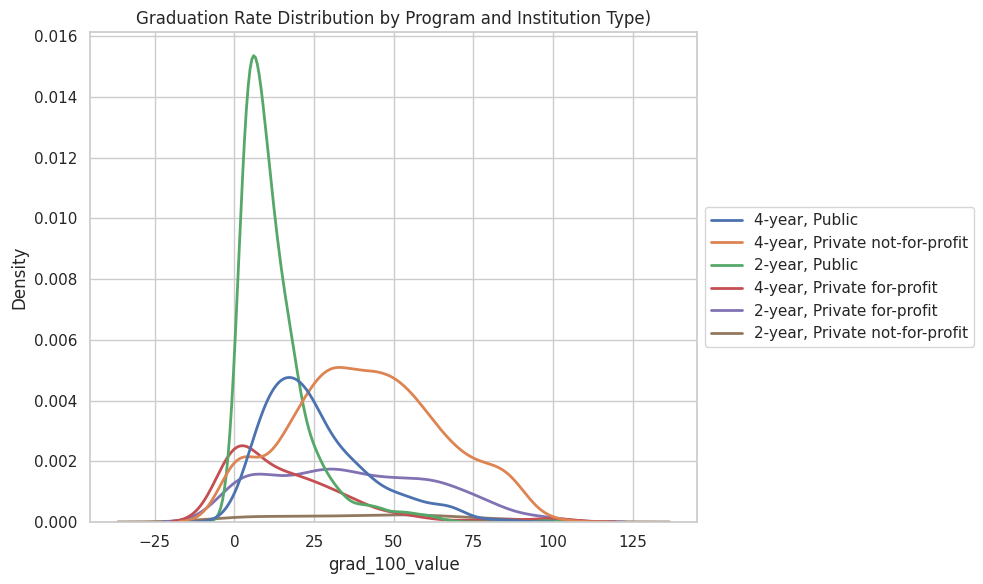

In [70]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(
    data=college_grp,
    x='grad_100_value',
    hue='levelXcontrol',
    linewidth=2,
    legend=False  # Disable seaborn's automatic legend
)

plt.title('Graduation Rate Distribution by Program and Institution Type)')
plt.xlabel('grad_100_value')
plt.ylabel('Density')

# Manually create legend
levels = college_grp['levelXcontrol'].unique()
colors = sns.color_palette(n_colors=len(levels))

# Create proxy artists for the legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=colors[i], lw=2, label=levels[i]) for i in range(len(levels))]

plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

2.7

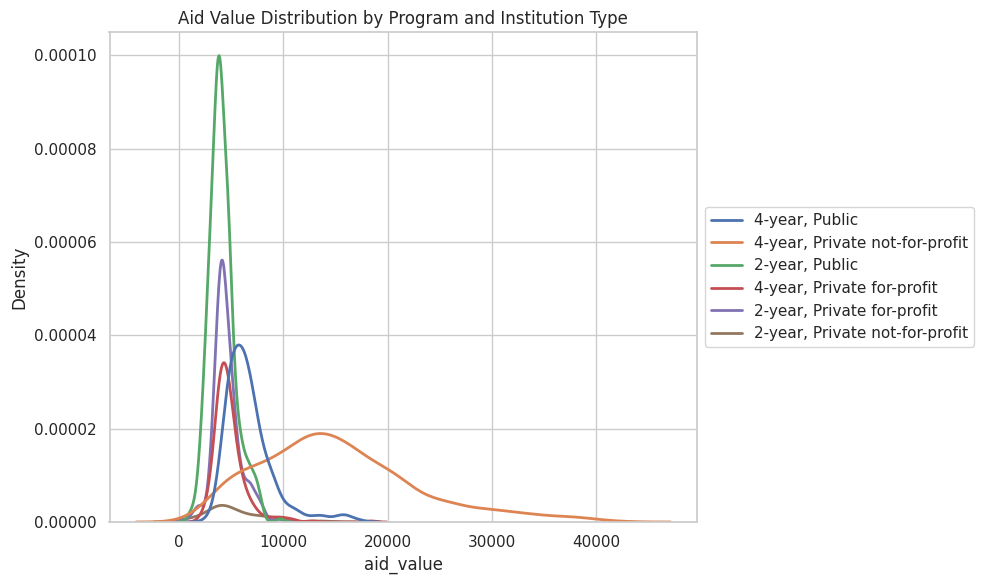

In [77]:
college_grp = college_grp.copy()  # make explicit copy to avoid warning
college_grp['levelXcontrol'] = college_grp['level'] + ', ' + college_grp['control']

plt.figure(figsize=(10, 6))
ax = sns.kdeplot(
    data=college_grp,
    x='aid_value',
    hue='levelXcontrol',
    linewidth=2,
    legend=False
)

plt.title('Aid Value Distribution by Program and Institution Type')
plt.xlabel('aid_value')
plt.ylabel('Density')

levels = college_grp['levelXcontrol'].unique()
colors = sns.color_palette(n_colors=len(levels))

legend_elements = list(map(lambda c_l: Line2D([0], [0], color=c_l[0], lw=2, label=c_l[1]), zip(colors, levels)))

plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [71]:
print(college_grp.groupby(['level', 'control'])['aid_value'].describe())

                                count          mean          std     min  \
level  control                                                             
2-year Private for-profit       460.0   4548.886957  1273.908071   294.0   
       Private not-for-profit    68.0   5128.058824  2590.449946   934.0   
       Public                   926.0   4126.199784  1260.271382   881.0   
4-year Private for-profit       318.0   4829.050314  1620.406400  2217.0   
       Private not-for-profit  1121.0  15111.199822  7549.163907  1450.0   
       Public                   573.0   6717.588133  2345.658634  2685.0   

                                   25%      50%       75%      max  
level  control                                                      
2-year Private for-profit      3814.75   4286.5   5104.25   9727.0  
       Private not-for-profit  3650.00   4516.5   6311.50  13654.0  
       Public                  3311.25   3943.5   4762.00   9809.0  
4-year Private for-profit      3908.00   4491.

2.8

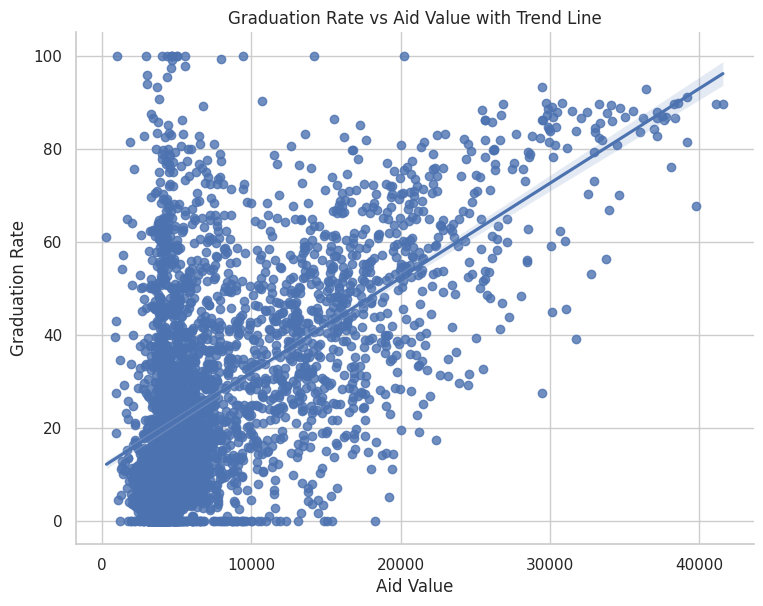

In [86]:
sns.lmplot(data=college, x='aid_value', y='grad_100_value', height=6, aspect=1.3)
plt.title('Graduation Rate vs Aid Value with Trend Line')
plt.xlabel('Aid Value')
plt.ylabel('Graduation Rate')
plt.show()

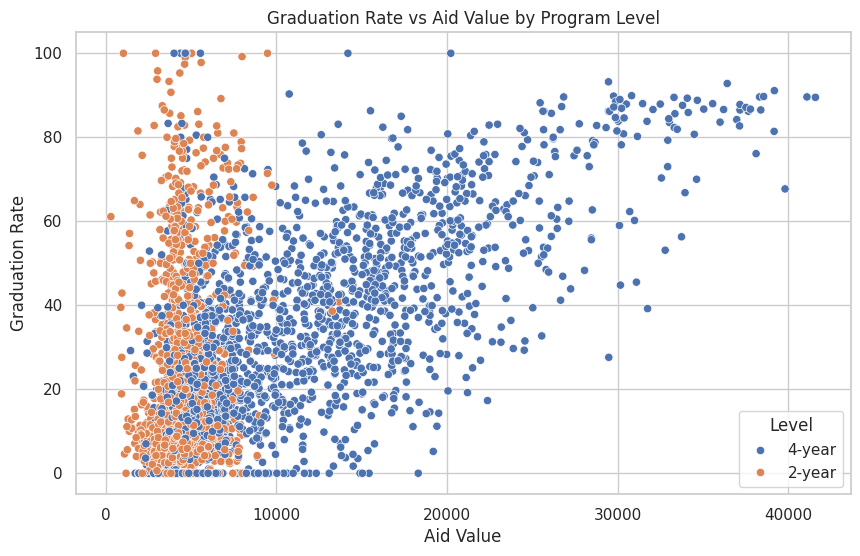

In [84]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=college, x='aid_value', y='grad_100_value', hue='level')
plt.title('Graduation Rate vs Aid Value by Program Level')
plt.xlabel('Aid Value')
plt.ylabel('Graduation Rate')
plt.legend(title='Level')
plt.show()


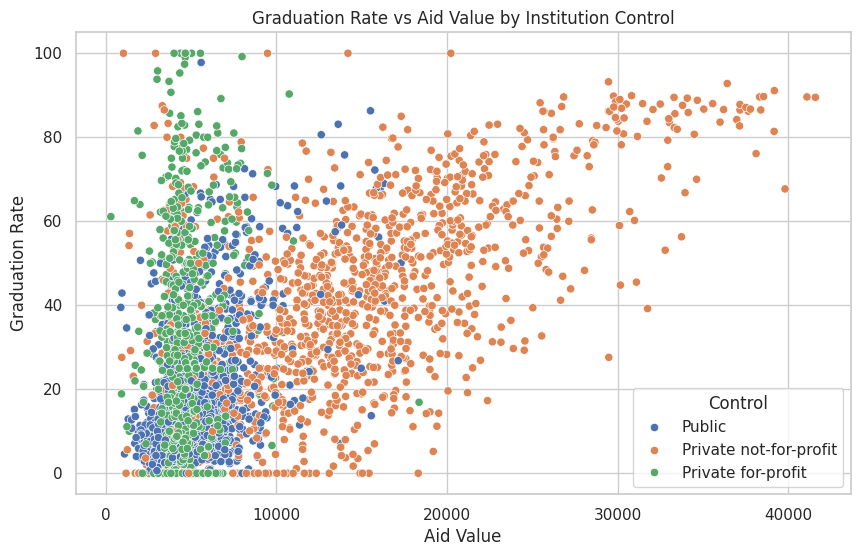

In [80]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=college, x='aid_value', y='grad_100_value', hue='control')
plt.title('Graduation Rate vs Aid Value by Institution Control')
plt.xlabel('Aid Value')
plt.ylabel('Graduation Rate')
plt.legend(title='Control')
plt.show()